# Importaciones

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass, shift
from sklearn.model_selection import train_test_split

2025-04-07 18:08:13.523867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 18:08:14.795537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744042095.213903    8930 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744042095.324904    8930 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744042096.433132    8930 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Comprobar GPU

Lo primero que se debe comprobar es si `TensorFlow` está haciendo uso de la **GPU**, para tener mayor capacidad de procesamiento.

In [2]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


I0000 00:00:1744042122.426247    8930 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Data Processing

## Dataset

In [3]:
# Cargar los datos
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Mostrar la forma de los datos
print(f"Forma de x_train: {x_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de x_test: {x_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de x_train: (60000, 28, 28)
Forma de y_train: (60000,)
Forma de x_test: (10000, 28, 28)
Forma de y_test: (10000,)


## Análisis exploratorio y visualización

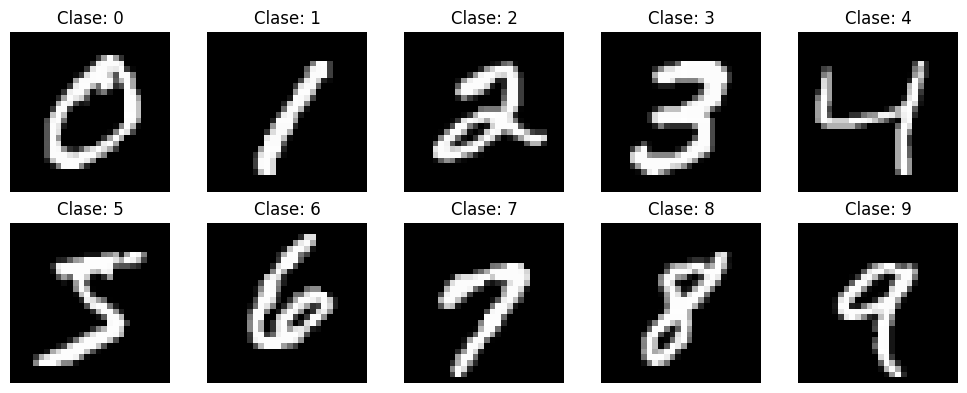

In [4]:
# Mostrar una muestra de cada clase (0-9)
plt.figure(figsize=(10, 4))
for i in range(10):
    idx = np.where(y_train == i)[0][0]  # primer índice de cada clase
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(f"Clase: {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

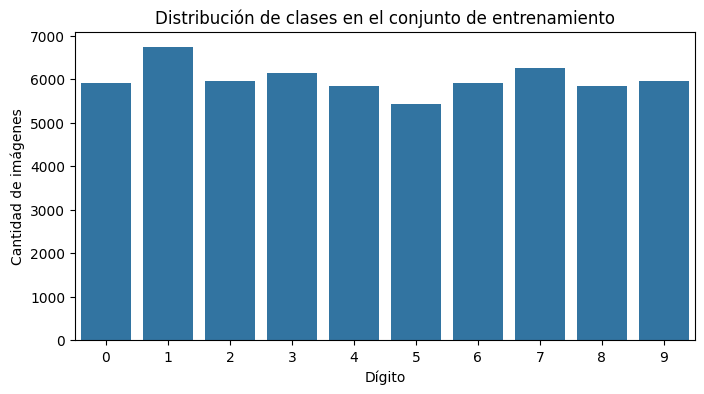

In [5]:
# Contar ocurrencias de cada etiqueta
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Dígito")
plt.ylabel("Cantidad de imágenes")
plt.show()

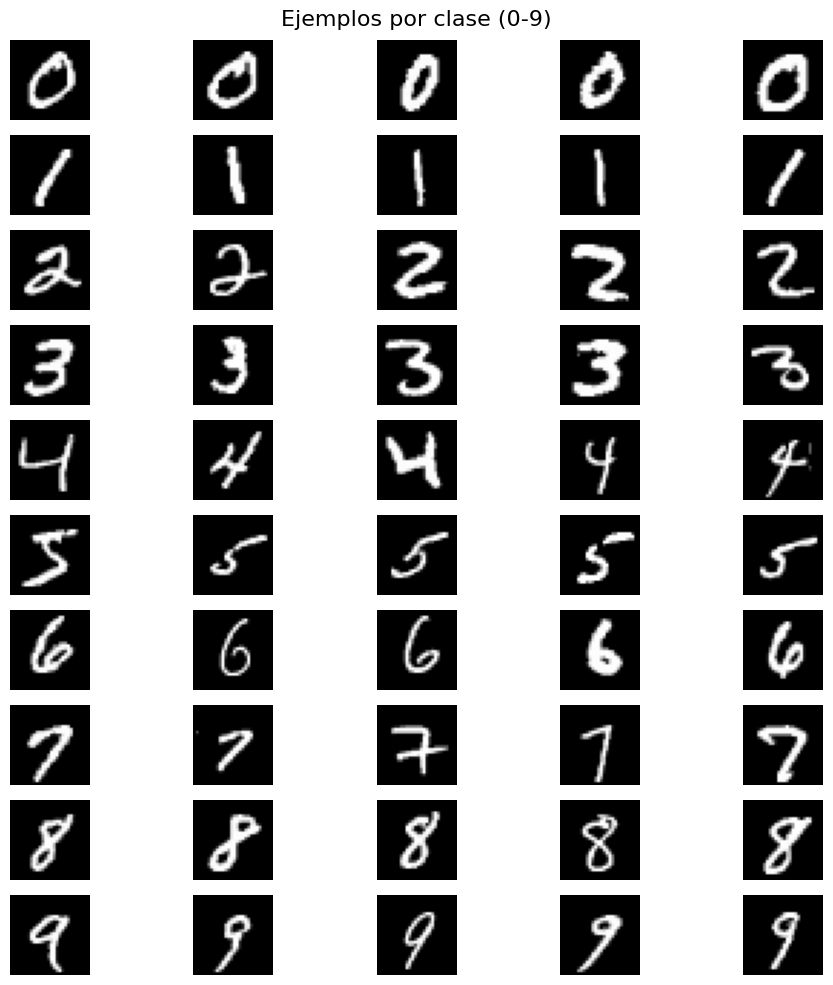

In [6]:
# Mostrar 5 imágenes por cada clase
plt.figure(figsize=(10, 10))
for i in range(10):  # clases 0 al 9
    indices = np.where(y_train == i)[0][:5]  # 5 primeras imágenes de cada clase
    for j, idx in enumerate(indices):
        plt.subplot(10, 5, i * 5 + j + 1)
        plt.imshow(x_train[idx].squeeze(), cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.ylabel(str(i), fontsize=12)  # poner etiqueta al principio de la fila
plt.suptitle("Ejemplos por clase (0-9)", fontsize=16)
plt.tight_layout()
plt.show()

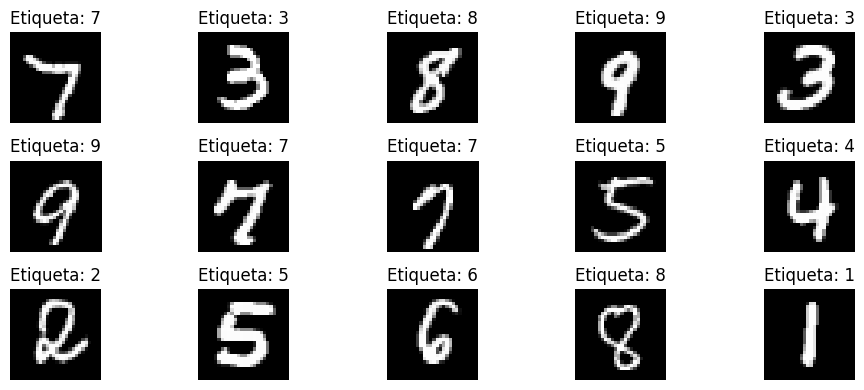

In [7]:
# Mostrar algunos dígitos que podrían parecer ruidosos o raros visualmente
np.random.seed(42)
random_idxs = np.random.choice(len(x_train), size=15, replace=False)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_idxs):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(f"Etiqueta: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

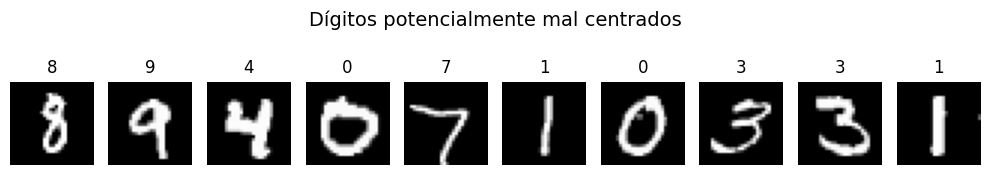

In [8]:
centers = np.array([center_of_mass(img.squeeze()) for img in x_train])
center_dist = np.linalg.norm(centers - np.array([14, 14]), axis=1)

# Mostrar imágenes con centro muy alejado del centro ideal (14,14)
off_center_indices = np.argsort(center_dist)[-10:]

plt.figure(figsize=(10, 2))
for i, idx in enumerate(off_center_indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(f"{y_train[idx]}")
    plt.axis('off')
plt.suptitle("Dígitos potencialmente mal centrados", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Función para centrar una imagen
def center_image(img):
    cy, cx = center_of_mass(img)
    shift_y = 14 - cy
    shift_x = 14 - cx
    return shift(img, shift=[shift_y, shift_x], mode='constant', cval=0.0)

# Aplicar a todas las imágenes del dataset
x_train = np.array([center_image(img.squeeze()) for img in x_train])
x_test = np.array([center_image(img.squeeze()) for img in x_test])

# Agregar la dimensión del canal para usar en Conv2D
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

## Limpieza y preprocesamiento de imágenes

In [10]:
# Crear el generador de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotar hasta 15 grados
    width_shift_range=0.1,  # Desplazamientos horizontales
    height_shift_range=0.1,  # Desplazamientos verticales
    zoom_range=0.1,  # Zoom aleatorio
    shear_range=0.1,  # Desplazamientos en ángulo
    brightness_range=[0.7, 1.3],  # Cambio de brillo
    horizontal_flip=False,  # No hace flip horizontal (ya que los dígitos no deben invertirse)
    fill_mode="nearest"  # Rellenar áreas vacías con el píxel más cercano
)

# Ajustar el generador al conjunto de datos de entrenamiento
datagen.fit(x_train)

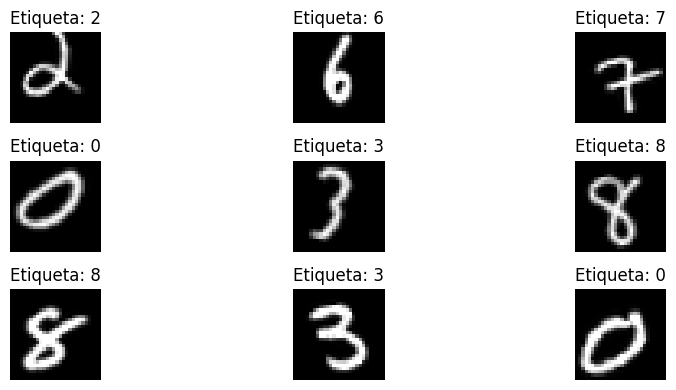

In [11]:
# Mostrar algunas imágenes aumentadas
plt.figure(figsize=(10, 4))
for i, (x_batch, y_batch) in enumerate(datagen.flow(x_train, y_train, batch_size=9)):
    if i > 0:  # Solo mostrar una tanda de imágenes aumentadas
        break
    for j in range(9):
        plt.subplot(3, 3, j + 1)
        plt.imshow(x_batch[j].squeeze(), cmap='gray')
        plt.title(f"Etiqueta: {y_batch[j]}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Crear un generador de imágenes aumentadas
augmented_images = []
augmented_labels = []

# Número de imágenes que queremos generar (20% de 60,000 -> 12,000 imágenes)
num_images_to_generate = int(0.2 * x_train.shape[0])

In [13]:
# Generar imágenes aumentadas
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32, shuffle=False, save_to_dir=None):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    
    # Salir después de generar las imágenes necesarias (12,000 imágenes)
    if len(augmented_images) * 32 >= num_images_to_generate:
        break

In [14]:
# Convertir a arrays de numpy
augmented_images = np.concatenate(augmented_images, axis=0)
augmented_labels = np.concatenate(augmented_labels, axis=0)

# Concatenar las imágenes aumentadas al dataset original
x_train = np.concatenate([x_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_labels], axis=0)

In [15]:
# Verificar la forma final de los datos
print(x_train.shape)  # Debería ser aproximadamente 72,000 imágenes (60,000 originales + 12,000 aumentadas)

(72000, 28, 28, 1)


In [16]:
# Normalizar los datos (escalar a valores entre 0 y 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10) 

# Dividir el conjunto de entrenamiento en entrenamiento y validación
# El conjunto de prueba (x_test, y_test) se mantiene intacto
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=42, stratify=y_train.argmax(axis=1)
)

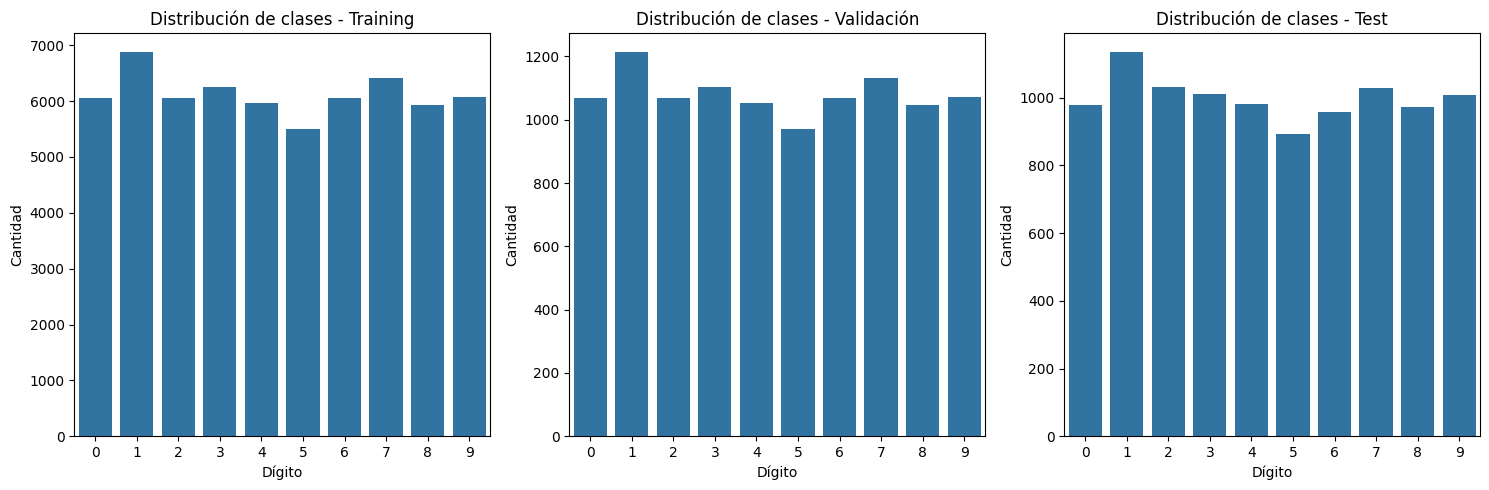

Conjunto de entrenamiento: 61200 imágenes
Conjunto de validación: 10800 imágenes
Conjunto de prueba: 10000 imágenes


In [17]:
# Verificar y visualizar la distribución de clases en cada conjunto
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 5))

# Crear subplots para cada conjunto de datos
plt.subplot(1, 3, 1)
sns.countplot(x=y_train_classes)
plt.title("Distribución de clases - Training")
plt.xlabel("Dígito")
plt.ylabel("Cantidad")

plt.subplot(1, 3, 2)
sns.countplot(x=y_val_classes)
plt.title("Distribución de clases - Validación")
plt.xlabel("Dígito")
plt.ylabel("Cantidad")

plt.subplot(1, 3, 3)
sns.countplot(x=y_test_classes)
plt.title("Distribución de clases - Test")
plt.xlabel("Dígito")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()

# Imprimir estadísticas de los conjuntos
print(f"Conjunto de entrenamiento: {x_train.shape[0]} imágenes")
print(f"Conjunto de validación: {x_val.shape[0]} imágenes")
print(f"Conjunto de prueba: {x_test.shape[0]} imágenes")

# Model planning

## Arquitectura de la Red Neuronal Convolucional

In [18]:
# Crear el modelo secuencial
model = Sequential()

# Capa Convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Capa de Pooling 1
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa Convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))

# Capa de Pooling 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar la salida de las capas convolucionales para la capa densa
model.add(Flatten())

# Capa Densa 1
model.add(Dense(128, activation='relu'))

# Capa de Salida
model.add(Dense(10, activation='softmax'))

# Resumen del modelo
model.summary()

/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-PostalCode/.venvWSL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Crear modelo mejorado
model_improved = Sequential()

# Capa Convolucional 1
model_improved.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Capa de Pooling 1
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

# Capa Convolucional 2 (Nueva)
model_improved.add(Conv2D(64, (3, 3), activation='relu'))

# Capa de Pooling 2 (Nueva)
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

# Capa Convolucional 3
model_improved.add(Conv2D(64, (3, 3), activation='relu'))

# Capa de Pooling 3
model_improved.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar la salida de las capas convolucionales para la capa densa
model_improved.add(Flatten())

# Capa Densa 1
model_improved.add(Dense(128, activation='relu'))

# Capa de Salida
model_improved.add(Dense(10, activation='softmax'))

# Resumen del modelo mejorado
model_improved.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,354 (255.29 KB)

 Trainable params: 65,354 (255.29 KB)

 Non-trainable params: 0 (0.00 B)

# Estrategia de Mejora y Experimentación

Vamos a comparar el modelo base con la versión mejorada evaluando la cantidad de parámetros, el tiempo de entrenamiento y el desempeño (accuracy, loss) de ambos modelos.

In [20]:
# Compilar ambos modelos con la misma configuración
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_improved.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [21]:
# Configurar callbacks para ambos modelos
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    # Se puede agregar más callbacks según sea necesario
]

In [22]:
# Función para calcular y mostrar la cantidad de parámetros de un modelo
def show_model_params(model, name):
    trainable_params = sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    print(f"{name}:")
    print(f"  Parámetros entrenables: {trainable_params:,}")
    print(f"  Parámetros no entrenables: {non_trainable_params:,}")
    print(f"  Total de parámetros: {trainable_params + non_trainable_params:,}")
    print()

In [23]:
# Comparar número de parámetros entre ambos modelos
# Actualizar la función show_model_params para usar la propiedad shape en lugar de get_shape()
def show_model_params(model, name):
	trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
	non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])
	print(f"{name}:")
	print(f"  Parámetros entrenables: {trainable_params:,}")
	print(f"  Parámetros no entrenables: {non_trainable_params:,}")
	print(f"  Total de parámetros: {trainable_params + non_trainable_params:,}")
	print()

show_model_params(model, "Modelo Base")
show_model_params(model_improved, "Modelo Mejorado")

Modelo Base:
  Parámetros entrenables: 225,034
  Parámetros no entrenables: 0
  Total de parámetros: 225,034

Modelo Mejorado:
  Parámetros entrenables: 65,354
  Parámetros no entrenables: 0
  Total de parámetros: 65,354



In [24]:
# Entrenamiento del modelo base con medición de tiempo
start_time_base = time.time()

history_base = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

end_time_base = time.time()
training_time_base = end_time_base - start_time_base
print(f"Tiempo de entrenamiento del modelo base: {training_time_base:.2f} segundos")

Epoch 1/20


I0000 00:00:1744042142.104192    9127 service.cc:152] XLA service 0x7f7cec00b9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744042142.104236    9127 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-07 18:09:02.212148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744042142.450398    9127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744042142.450398    9127 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-07 18:09:03.426810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_276', 4 bytes spill stores, 4 bytes spill loads

2025-04-07 18:09:03.426810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc

 22/957 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3758 - loss: 2.0737

I0000 00:00:1744042147.600529    9127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


957/957 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8724 - loss: 0.4380 - val_accuracy: 0.9661 - val_loss: 0.1041
Epoch 2/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8724 - loss: 0.4380 - val_accuracy: 0.9661 - val_loss: 0.1041
Epoch 2/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9777 - loss: 0.0726 - val_accuracy: 0.9778 - val_loss: 0.0683
Epoch 3/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9777 - loss: 0.0726 - val_accuracy: 0.9778 - val_loss: 0.0683
Epoch 3/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9860 - loss: 0.0462 - val_accuracy: 0.9810 - val_loss: 0.0589
Epoch 4/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9860 - loss: 0.0462 - val_accuracy: 0.9810 - val_loss: 0.0589
Epoch 4/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9899 - loss: 0.0328 - val_accuracy: 0.9837 - val_loss: 0.0514
Epoch 5/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9899 - loss: 0.0328 - val_accuracy: 0.9837 - va

In [25]:
# Entrenamiento del modelo mejorado con medición de tiempo
start_time_improved = time.time()

history_improved = model_improved.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

end_time_improved = time.time()
training_time_improved = end_time_improved - start_time_improved
print(f"Tiempo de entrenamiento del modelo mejorado: {training_time_improved:.2f} segundos")

Epoch 1/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7994 - loss: 0.6334 - val_accuracy: 0.9538 - val_loss: 0.1524
Epoch 2/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7994 - loss: 0.6334 - val_accuracy: 0.9538 - val_loss: 0.1524
Epoch 2/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9610 - loss: 0.1285 - val_accuracy: 0.9630 - val_loss: 0.1146
Epoch 3/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9610 - loss: 0.1285 - val_accuracy: 0.9630 - val_loss: 0.1146
Epoch 3/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9727 - loss: 0.0896 - val_accuracy: 0.9690 - val_loss: 0.1035
Epoch 4/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9727 - loss: 0.0896 - val_accuracy: 0.9690 - val_loss: 0.1035
Epoch 4/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9782 - loss: 0.0700 - val_accuracy: 0.9728 - val_loss: 0.0883
Epoch 5/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9782 - loss: 0.0700 - val_accuracy: 0.

In [26]:
# Función para evaluar y mostrar resultados del modelo
def evaluate_and_show(model, name, x_test, y_test, history):
    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # Obtener valores finales de entrenamiento
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    # Mostrar resultados
    print(f"Resultados de {name}:")
    print(f"  Accuracy de entrenamiento: {final_train_acc:.4f}")
    print(f"  Accuracy de validación: {final_val_acc:.4f}")
    print(f"  Accuracy de prueba: {test_accuracy:.4f}")
    print(f"  Loss de entrenamiento: {final_train_loss:.4f}")
    print(f"  Loss de validación: {final_val_loss:.4f}")
    print(f"  Loss de prueba: {test_loss:.4f}")
    print()
    
    return test_accuracy, test_loss

In [27]:
# Evaluar ambos modelos
base_acc, base_loss = evaluate_and_show(model, "Modelo Base", x_test, y_test, history_base)
improved_acc, improved_loss = evaluate_and_show(model_improved, "Modelo Mejorado", x_test, y_test, history_improved)

2025-04-07 18:12:22.650911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 4 bytes spill stores, 4 bytes spill loads



Resultados de Modelo Base:
  Accuracy de entrenamiento: 0.9972
  Accuracy de validación: 0.9863
  Accuracy de prueba: 0.9922
  Loss de entrenamiento: 0.0088
  Loss de validación: 0.0561
  Loss de prueba: 0.0249

Resultados de Modelo Mejorado:
  Accuracy de entrenamiento: 0.9954
  Accuracy de validación: 0.9819
  Accuracy de prueba: 0.9884
  Loss de entrenamiento: 0.0135
  Loss de validación: 0.0791
  Loss de prueba: 0.0448



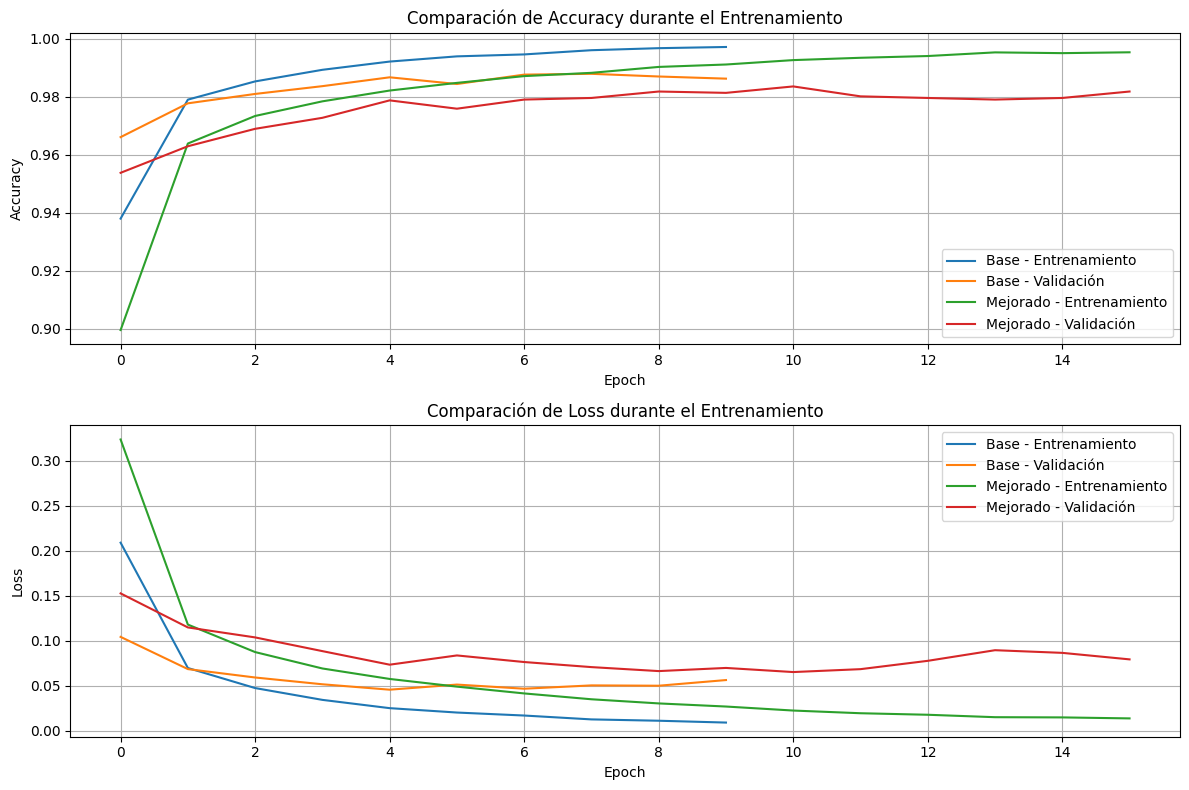

In [28]:
# Comparar visualmente las curvas de entrenamiento
plt.figure(figsize=(12, 8))

# Gráfica de exactitud (accuracy)
plt.subplot(2, 1, 1)
plt.plot(history_base.history['accuracy'], label='Base - Entrenamiento')
plt.plot(history_base.history['val_accuracy'], label='Base - Validación')
plt.plot(history_improved.history['accuracy'], label='Mejorado - Entrenamiento')
plt.plot(history_improved.history['val_accuracy'], label='Mejorado - Validación')
plt.title('Comparación de Accuracy durante el Entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Gráfica de pérdida (loss)
plt.subplot(2, 1, 2)
plt.plot(history_base.history['loss'], label='Base - Entrenamiento')
plt.plot(history_base.history['val_loss'], label='Base - Validación')
plt.plot(history_improved.history['loss'], label='Mejorado - Entrenamiento')
plt.plot(history_improved.history['val_loss'], label='Mejorado - Validación')
plt.title('Comparación de Loss durante el Entrenamiento')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Crear un modelo base optimizado utilizando regularizadores y dropout

# Crear un modelo con regularización y dropout
model_optimized = Sequential()

# Capa Convolucional 1
model_optimized.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), 
                         kernel_regularizer=l2(0.001)))
model_optimized.add(MaxPooling2D(pool_size=(2, 2)))
model_optimized.add(Dropout(0.25))

# Capa Convolucional 2
model_optimized.add(Conv2D(64, (3, 3), activation='relu', 
                         kernel_regularizer=l2(0.001)))
model_optimized.add(MaxPooling2D(pool_size=(2, 2)))
model_optimized.add(Dropout(0.25))

# Aplanar
model_optimized.add(Flatten())

# Capa Densa 1
model_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_optimized.add(Dropout(0.5))

# Capa de Salida
model_optimized.add(Dense(10, activation='softmax'))

# Resumen del modelo optimizado
model_optimized.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Compilar con una tasa de aprendizaje personalizada y probar diferentes configuraciones
hyperparams = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.2, 0.25, 0.3]
}

# Para guardar resultados
results = []

# Para hacer un seguimiento de la mejor configuración
best_val_acc = 0
best_config = {}

In [31]:
# Ciclo para probar diferentes combinaciones de hiperparámetros
for lr in hyperparams['learning_rate']:
    for bs in hyperparams['batch_size']:
        for dr in hyperparams['dropout_rate']:
            print(f"\nProbando: LR={lr}, Batch Size={bs}, Dropout Rate={dr}")
            
            # Recrear el modelo con la tasa de dropout actual
            model_optimized = Sequential()
            model_optimized.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), 
                             kernel_regularizer=l2(0.001)))
            model_optimized.add(MaxPooling2D(pool_size=(2, 2)))
            model_optimized.add(Dropout(dr))
            
            model_optimized.add(Conv2D(64, (3, 3), activation='relu', 
                             kernel_regularizer=l2(0.001)))
            model_optimized.add(MaxPooling2D(pool_size=(2, 2)))
            model_optimized.add(Dropout(dr))
            
            model_optimized.add(Flatten())
            model_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
            model_optimized.add(Dropout(dr))
            model_optimized.add(Dense(10, activation='softmax'))
            
            # Configurar el optimizador con la tasa de aprendizaje actual
            optimizer = Adam(learning_rate=lr)
            model_optimized.compile(
                optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            # Entrenar con early stopping para ser más eficientes
            start_time = time.time()
            
            history = model_optimized.fit(
                x_train, y_train,
                batch_size=bs,
                epochs=10,  # Reducimos épocas para pruebas más rápidas
                validation_data=(x_val, y_val),
                callbacks=callbacks,
                verbose=1
            )
            
            training_time = time.time() - start_time
            
            # Evaluar el modelo
            val_loss, val_acc = model_optimized.evaluate(x_val, y_val, verbose=0)
            
            # Guardar resultados
            results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'dropout_rate': dr,
                'val_accuracy': val_acc,
                'val_loss': val_loss,
                'training_time': training_time
            })
            
            # Actualizar mejor configuración
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_config = {
                    'learning_rate': lr,
                    'batch_size': bs,
                    'dropout_rate': dr
                }


Probando: LR=0.001, Batch Size=64, Dropout Rate=0.2
Epoch 1/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8357 - loss: 0.7339 - val_accuracy: 0.9613 - val_loss: 0.2556
Epoch 2/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9607 - loss: 0.2538 - val_accuracy: 0.9731 - val_loss: 0.1932
Epoch 3/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9658 - loss: 0.2205 - val_accuracy: 0.9767 - val_loss: 0.1857
Epoch 4/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9675 - loss: 0.2073 - val_accuracy: 0.9788 - val_loss: 0.1726
Epoch 5/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9712 - loss: 0.1982 - val_accuracy: 0.9754 - val_loss: 0.1787
Epoch 6/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9709 - loss: 0.1967 - val_accuracy: 0.9771 - val_loss: 0.1683
Epoch 7/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9722 - loss: 0.1893 - val_accuracy: 0.9763 - val_loss: 0.1711
Epoch 8/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/ste

2025-04-07 18:15:31.920374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



479/479 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7832 - loss: 0.8907 - val_accuracy: 0.9659 - val_loss: 0.2561
Epoch 2/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9587 - loss: 0.2699 - val_accuracy: 0.9734 - val_loss: 0.1968
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9653 - loss: 0.2208 - val_accuracy: 0.9756 - val_loss: 0.1777
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9687 - loss: 0.2006 - val_accuracy: 0.9794 - val_loss: 0.1596
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9727 - loss: 0.1843 - val_accuracy: 0.9775 - val_loss: 0.1651
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9727 - loss: 0.1799 - val_accuracy: 0.9794 - val_loss: 0.1536
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9742 - loss: 0.1726 - val_accuracy: 0.9811 - val_loss: 0.1497
Epoch 8/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9756 - loss: 0.1695 - val_accuracy: 0.9808 - va

2025-04-07 18:17:41.879351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7355 - loss: 1.0630 - val_accuracy: 0.9557 - val_loss: 0.3268
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9502 - loss: 0.3313 - val_accuracy: 0.9661 - val_loss: 0.2356
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9608 - loss: 0.2549 - val_accuracy: 0.9703 - val_loss: 0.2040
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9627 - loss: 0.2220 - val_accuracy: 0.9739 - val_loss: 0.1776
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9678 - loss: 0.1960 - val_accuracy: 0.9787 - val_loss: 0.1581
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9708 - loss: 0.1800 - val_accuracy: 0.9785 - val_loss: 0.1525
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9722 - loss: 0.1796 - val_accuracy: 0.9796 - val_loss: 0.1476
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9739 - loss: 0.1669 - val_accuracy: 0.97

In [32]:
# Mostrar resultados ordenados por precisión de validación
print("\nResultados ordenados por precisión de validación:")
for i, result in enumerate(sorted(results, key=lambda x: x['val_accuracy'], reverse=True)):
    print(f"{i+1}. LR={result['learning_rate']}, BS={result['batch_size']}, DR={result['dropout_rate']}: "
          f"Val Acc={result['val_accuracy']:.4f}, Val Loss={result['val_loss']:.4f}, Time={result['training_time']:.2f}s")

print(f"\nMejor configuración: {best_config}")


Resultados ordenados por precisión de validación:
1. LR=0.001, BS=64, DR=0.25: Val Acc=0.9819, Val Loss=0.1614, Time=44.01s
2. LR=0.0005, BS=128, DR=0.2: Val Acc=0.9819, Val Loss=0.1339, Time=42.46s
3. LR=0.001, BS=256, DR=0.25: Val Acc=0.9817, Val Loss=0.1453, Time=30.08s
4. LR=0.0005, BS=64, DR=0.3: Val Acc=0.9816, Val Loss=0.1493, Time=50.42s
5. LR=0.0005, BS=64, DR=0.2: Val Acc=0.9815, Val Loss=0.1384, Time=54.60s
6. LR=0.001, BS=128, DR=0.2: Val Acc=0.9814, Val Loss=0.1467, Time=44.40s
7. LR=0.001, BS=64, DR=0.2: Val Acc=0.9806, Val Loss=0.1576, Time=48.00s
8. LR=0.0005, BS=128, DR=0.3: Val Acc=0.9806, Val Loss=0.1469, Time=42.97s
9. LR=0.001, BS=64, DR=0.3: Val Acc=0.9805, Val Loss=0.1758, Time=44.77s
10. LR=0.001, BS=256, DR=0.3: Val Acc=0.9805, Val Loss=0.1540, Time=29.47s
11. LR=0.001, BS=128, DR=0.3: Val Acc=0.9804, Val Loss=0.1631, Time=40.36s
12. LR=0.001, BS=128, DR=0.25: Val Acc=0.9801, Val Loss=0.1556, Time=40.89s
13. LR=0.0005, BS=64, DR=0.25: Val Acc=0.9799, Val Loss=

In [36]:
# Create the final model with the best configuration found
final_model = Sequential()

# Convolutional layer 1
final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), 
                     kernel_regularizer=l2(0.001)))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Dropout(best_config['dropout_rate']))

# Convolutional layer 2
final_model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_regularizer=l2(0.001)))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Dropout(best_config['dropout_rate']))

# Flatten layer
final_model.add(Flatten())

# Dense layer
final_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
final_model.add(Dropout(best_config['dropout_rate']))

# Output layer
final_model.add(Dense(10, activation='softmax'))

/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-PostalCode/.venvWSL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compile with the optimal learning rate
optimizer = Adam(learning_rate=best_config['learning_rate'])
final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
# Train the final model with more epochs
start_time_opt = time.time()

history_opt = final_model.fit(
    x_train, y_train,
    batch_size=best_config['batch_size'],
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time_opt = time.time() - start_time_opt
print(f"Final model training time: {training_time_opt:.2f} seconds")

Epoch 1/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8086 - loss: 0.7979 - val_accuracy: 0.9641 - val_loss: 0.2527
Epoch 2/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9562 - loss: 0.2756 - val_accuracy: 0.9694 - val_loss: 0.2098
Epoch 3/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9628 - loss: 0.2362 - val_accuracy: 0.9736 - val_loss: 0.1911
Epoch 4/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9661 - loss: 0.2195 - val_accuracy: 0.9769 - val_loss: 0.1795
Epoch 5/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9670 - loss: 0.2160 - val_accuracy: 0.9781 - val_loss: 0.1785
Epoch 6/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9694 - loss: 0.2064 - val_accuracy: 0.9789 - val_loss: 0.1741
Epoch 7/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9693 - loss: 0.2055 - val_accuracy: 0.9783 - val_loss: 0.1774
Epoch 8/20
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9704 - loss: 0.2012 - val_accuracy: 0

In [39]:
# Evaluate the final model
final_test_loss, final_test_acc = final_model.evaluate(x_test, y_test, verbose=1)
print(f"Final model test accuracy: {final_test_acc:.4f}")
print(f"Final model test loss: {final_test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9893 - loss: 0.1267
Final model test accuracy: 0.9910
Final model test loss: 0.1215


In [40]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

# Implementar validación cruzada K-Fold (k=5) para el modelo final

# Configurar la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Reunir datos de entrenamiento y validación para CV
X_combined = np.concatenate([x_train, x_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Guardar métricas para cada fold
cv_scores = []
cv_histories = []

# Ejecutar validación cruzada
for fold, (train_idx, val_idx) in enumerate(kf.split(X_combined)):
    print(f"\nFold {fold+1}/5")
    
    # Dividir datos para este fold
    X_fold_train, X_fold_val = X_combined[train_idx], X_combined[val_idx]
    y_fold_train, y_fold_val = y_combined[train_idx], y_combined[val_idx]
    
    # Crear una copia fresca del modelo final para cada fold
    fold_model = Sequential()
    fold_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), 
                        kernel_regularizer=l2(0.001)))
    fold_model.add(MaxPooling2D(pool_size=(2, 2)))
    fold_model.add(Dropout(best_config['dropout_rate']))
    
    fold_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    fold_model.add(MaxPooling2D(pool_size=(2, 2)))
    fold_model.add(Dropout(best_config['dropout_rate']))
    
    fold_model.add(Flatten())
    fold_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    fold_model.add(Dropout(best_config['dropout_rate']))
    fold_model.add(Dense(10, activation='softmax'))
    
    # Compilar modelo
    fold_model.compile(
        optimizer=Adam(learning_rate=best_config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Entrenar modelo para este fold
    fold_history = fold_model.fit(
        X_fold_train, y_fold_train,
        batch_size=best_config['batch_size'],
        epochs=10,  # Reducir épocas para completar la CV en un tiempo razonable
        validation_data=(X_fold_val, y_fold_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluar en el conjunto de validación de este fold
    val_loss, val_acc = fold_model.evaluate(X_fold_val, y_fold_val, verbose=0)
    
    # Evaluar en el conjunto de prueba
    test_loss, test_acc = fold_model.evaluate(x_test, y_test, verbose=0)
    
    # Guardar resultados
    cv_scores.append({
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })
    
    cv_histories.append(fold_history.history)
    
    print(f"Fold {fold+1} - Validation Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Fold 1/5


/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-PostalCode/.venvWSL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8132 - loss: 0.7941 - val_accuracy: 0.9689 - val_loss: 0.2459
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9556 - loss: 0.2758 - val_accuracy: 0.9731 - val_loss: 0.2079
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9630 - loss: 0.2360 - val_accuracy: 0.9761 - val_loss: 0.1946
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9649 - loss: 0.2285 - val_accuracy: 0.9764 - val_loss: 0.1853
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9667 - loss: 0.2173 - val_accuracy: 0.9774 - val_loss: 0.1890
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9670 - loss: 0.2164 - val_accuracy: 0.9795 - val_loss: 0.1755
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9703 - loss: 0.2030 - val_accuracy: 0.9776 - val_loss: 0.1803
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9690 - loss: 0.2074 - val_accuracy: 0.

In [41]:
# Calcular y mostrar resultados promedio
avg_val_acc = np.mean([score['val_accuracy'] for score in cv_scores])
avg_test_acc = np.mean([score['test_accuracy'] for score in cv_scores])
std_val_acc = np.std([score['val_accuracy'] for score in cv_scores])
std_test_acc = np.std([score['test_accuracy'] for score in cv_scores])

print("\n=== Cross-Validation Results ===")
print(f"Validation Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Test Accuracy: {avg_test_acc:.4f} ± {std_test_acc:.4f}")


=== Cross-Validation Results ===
Validation Accuracy: 0.9820 ± 0.0011
Test Accuracy: 0.9898 ± 0.0010


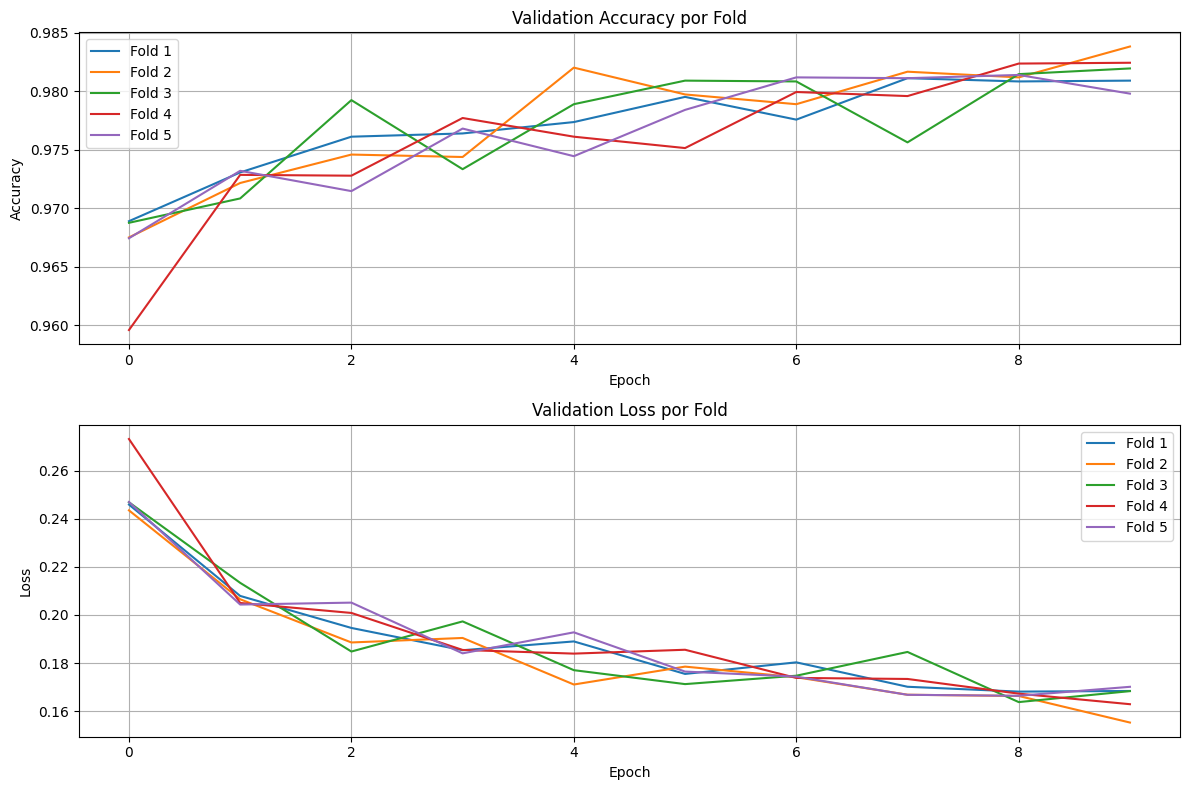

In [42]:
# Visualizar resultados de la validación cruzada
plt.figure(figsize=(12, 8))

# Gráfica de accuracy por fold
plt.subplot(2, 1, 1)
for i, history in enumerate(cv_histories):
    plt.plot(history['val_accuracy'], label=f'Fold {i+1}')
plt.title('Validation Accuracy por Fold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Gráfica de loss por fold
plt.subplot(2, 1, 2)
for i, history in enumerate(cv_histories):
    plt.plot(history['val_loss'], label=f'Fold {i+1}')
plt.title('Validation Loss por Fold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


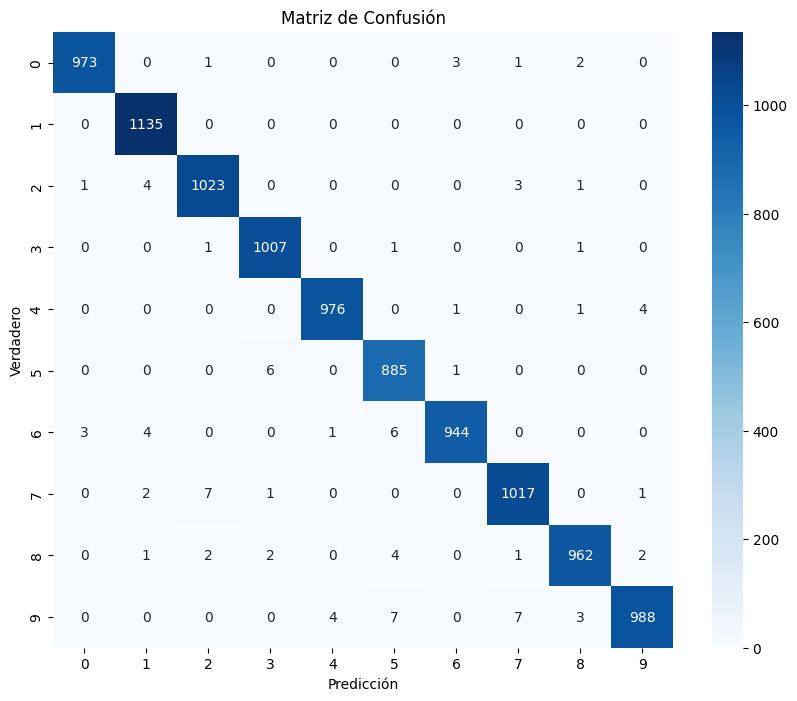

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo final
y_pred = final_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [44]:
# Calcular la precisión por clase
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Precisión para dígito {i}: {acc:.4f}")

# Identificar las confusiones más comunes
mistakes = []
for i in range(10):
    for j in range(10):
        if i != j:
            mistakes.append((i, j, conf_matrix[i, j]))

# Ordenar por la cantidad de errores
mistakes.sort(key=lambda x: x[2], reverse=True)

print("\nConfusiones más comunes:")
for true_digit, pred_digit, count in mistakes[:5]:
    print(f"Verdadero: {true_digit}, Predicho: {pred_digit}, Cantidad: {count}")

Precisión para dígito 0: 0.9929
Precisión para dígito 1: 1.0000
Precisión para dígito 2: 0.9913
Precisión para dígito 3: 0.9970
Precisión para dígito 4: 0.9939
Precisión para dígito 5: 0.9922
Precisión para dígito 6: 0.9854
Precisión para dígito 7: 0.9893
Precisión para dígito 8: 0.9877
Precisión para dígito 9: 0.9792

Confusiones más comunes:
Verdadero: 7, Predicho: 2, Cantidad: 7
Verdadero: 9, Predicho: 5, Cantidad: 7
Verdadero: 9, Predicho: 7, Cantidad: 7
Verdadero: 5, Predicho: 3, Cantidad: 6
Verdadero: 6, Predicho: 5, Cantidad: 6
